In [1]:
import data_reader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
path2submitsA  = 'iui20_ideaSubmits.csv'
path2requestsA = 'iui20_inspirationRequests.csv'

path2submitsB  = 'iui20_ideaSubmitsPart2.csv'
path2requestsB = 'iui20_inspirationRequestsPart2.csv'

seconds_per_bucket = 30
train_percentage = 0.1

In [3]:
#load data as sessions
sessionsA = data_reader.load_data_as_sessions_dict(path2submitsA, path2requestsA, seconds_per_bucket)
sessionsB = data_reader.load_data_as_sessions_dict(path2submitsB, path2requestsB, seconds_per_bucket)
# calculate avoiders and seekers
sessionsA = data_reader.add_avoiders_and_seekers(sessionsA)
sessionsB = data_reader.add_avoiders_and_seekers(sessionsB)
# create train and test set of worker ids
# NOT needed here because the entire sessionA is trainset and the entire sessionB is the testset
#train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessionsA, train_percentage=train_percentage)
#train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessionsB, train_percentage=train_percentage)

[[ 3 56  2 61]
 [55  4 31 32]
 [55  4 26 37]
 [49 10 27 36]
 [44 15 24 39]
 [51  8 24 39]
 [55  4 26 37]
 [54  5 27 36]
 [57  2 29 34]]


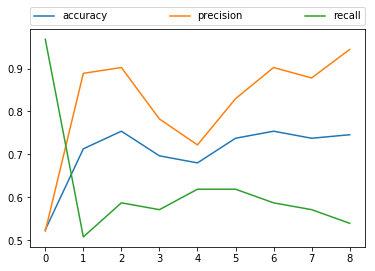

In [4]:
# iterate through different numbers of buckets
# train a classifier for each different numbers of buckets
# test on test examples
# get roc curve
conf_matrices = []
max_number_of_buckets = 10
for nr_of_buckets in range(1, max_number_of_buckets):
    train_worker_ids = list(sessionsA.keys())
    x_tr, y_tr, _, _ = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, [], sessionsA, train_percentage)
    test_worker_ids  = list(sessionsB.keys())
    _, _, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, [], test_worker_ids, sessionsB, train_percentage)
    #clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(200)
    clf.fit(x_tr, y_tr)
    y_pre = clf.predict(x_te)
    conf_matrices.append(confusion_matrix(y_te, y_pre))
    
# [[tn, fp, fn, tp], ...]
conf_matrices = np.array([conf_m.ravel() for conf_m in conf_matrices])
accuracies = [(cm[0]+cm[3])/sum(cm) for cm in conf_matrices]
precisions = [cm[3]/(cm[3]+cm[1])   for cm in conf_matrices]
recall     = [cm[3]/(cm[3]+cm[2])   for cm in conf_matrices]

print(conf_matrices)

plt.plot(accuracies, label='accuracy')
plt.plot(precisions, label='precision')
plt.plot(recall,     label='recall')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.show()

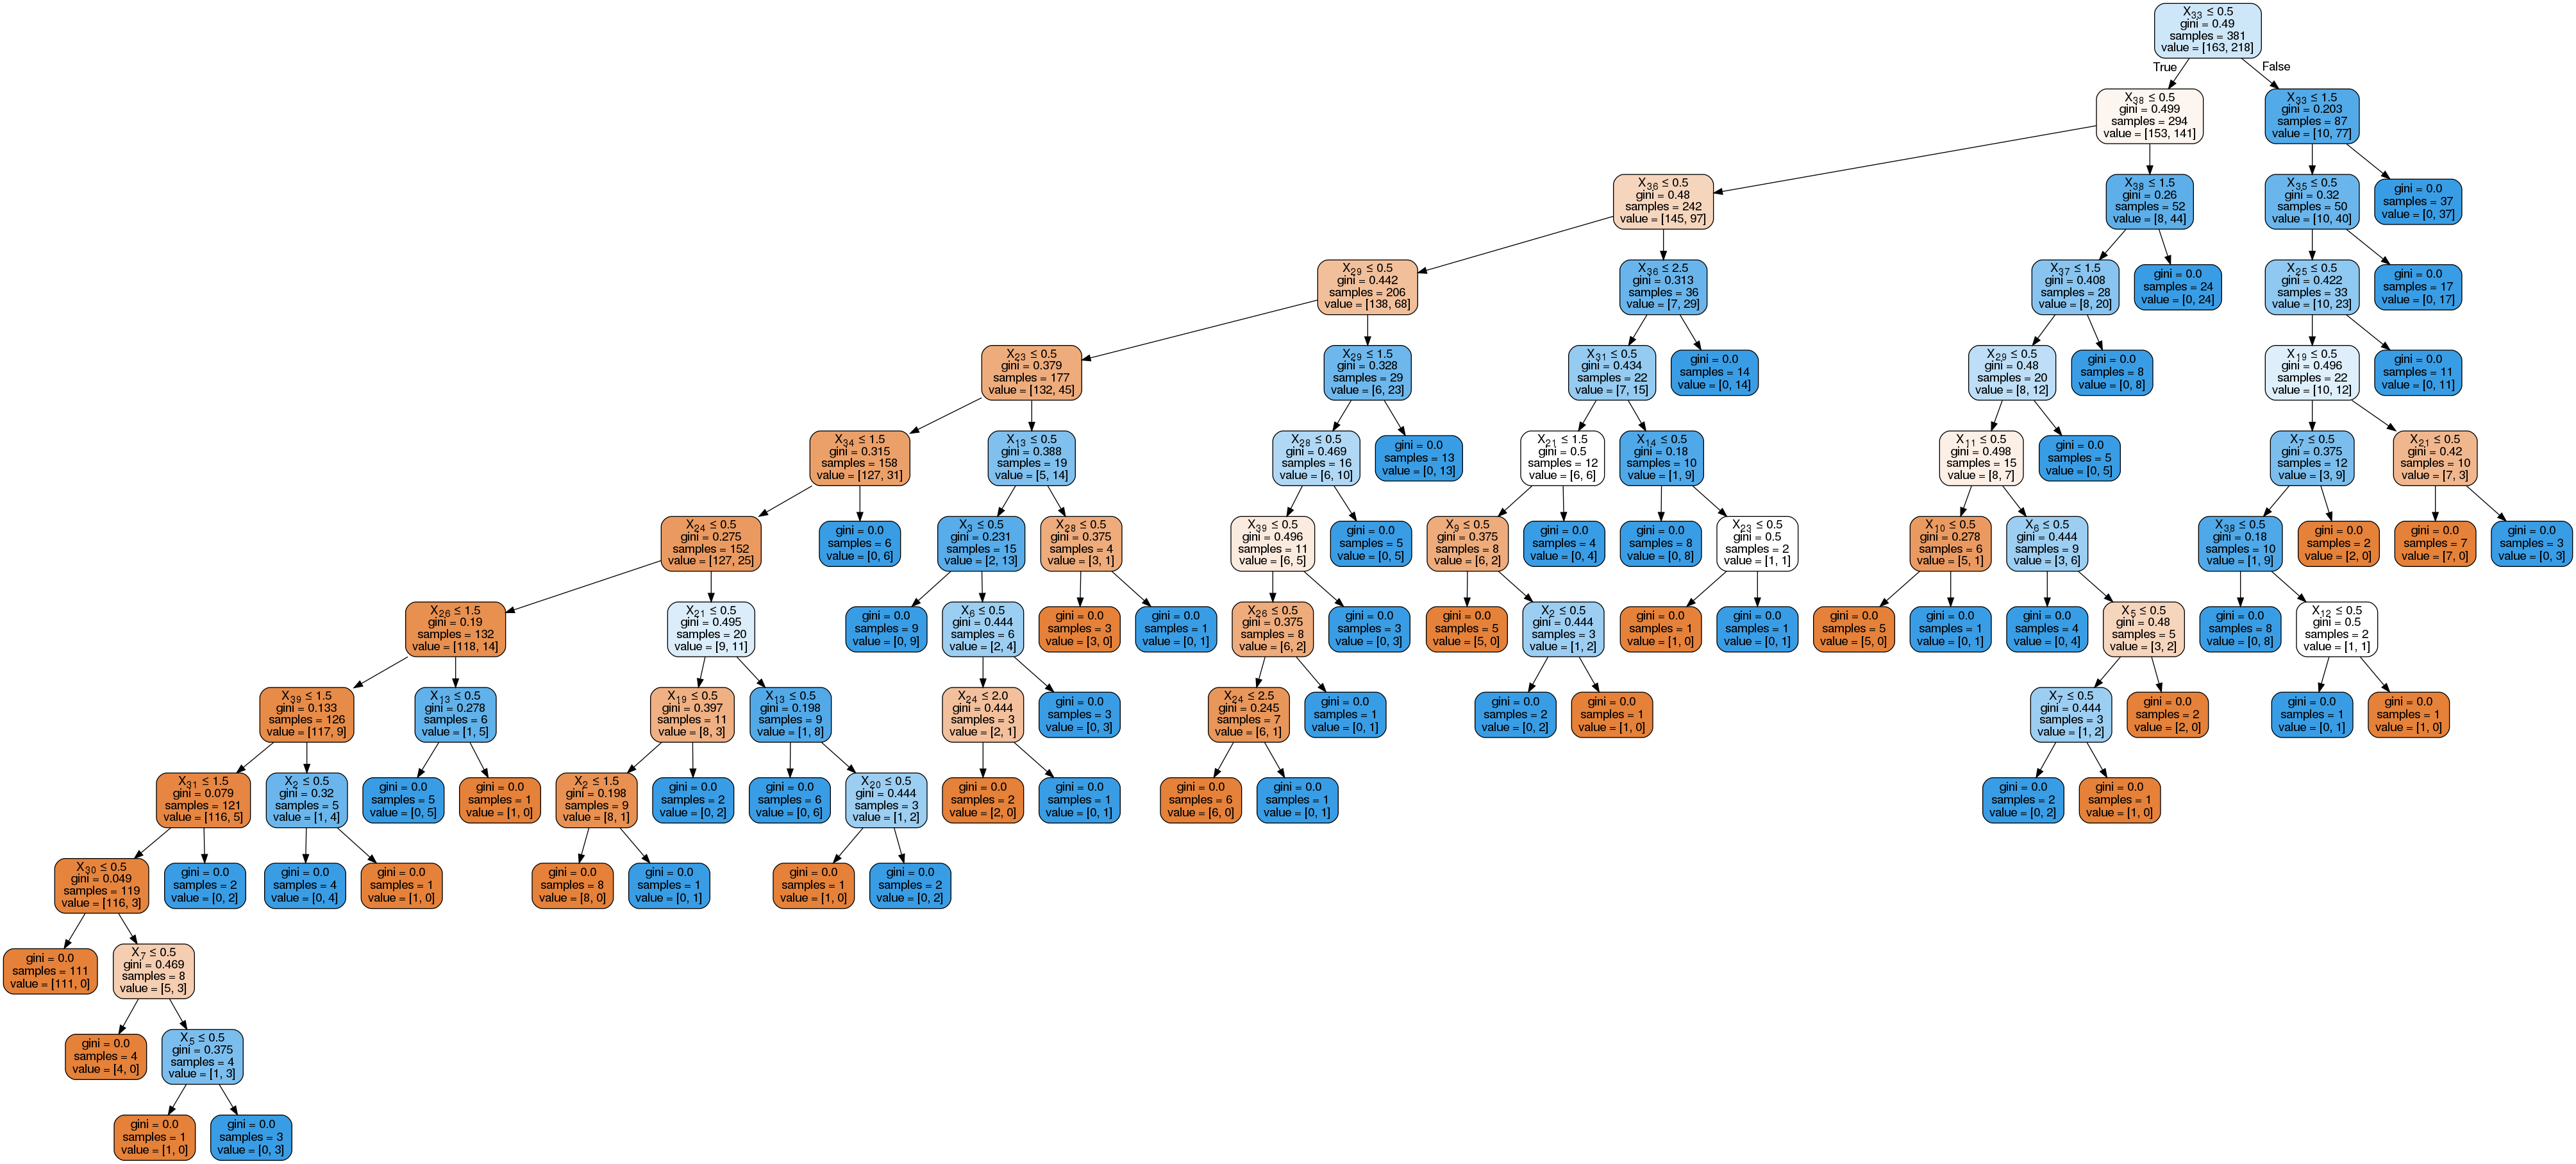

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

train_percentage = 1.0
nr_of_buckets = 20

train_worker_ids = list(sessionsA.keys())
x_tr, y_tr, _, _ = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, [], sessionsA, train_percentage)
test_worker_ids  = list(sessionsB.keys())
_, _, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, [], test_worker_ids, sessionsB, train_percentage)

clf = DecisionTreeClassifier()
clf.fit(x_tr, y_tr)
    
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())